## ZILLOW PREDICTING TAX ASSESSED VALUES 
## FINAL REPORT


Project & Report Created By: Rachel Robbins-Mayhill 2022-03-29

---

## PROJECT DESCRIPTION

Zillow is the leading real estate and rental marketplace dedicated to empowering consumers with data, inspiration and knowledge around the place they call home, and connecting them with the best local professionals who can help. According to the National Association of Realtors, there are over 119 million homes in the United States, over 5 million of which are sold each year. 80% of these homes have been viewed on Zillow regardless of their market status.

Zillow serves the full lifecycle of owning and living in a home: buying, selling, renting, financing, remodeling and more. It starts with Zillow's living database of more than 110 million U.S. homes - including homes for sale, homes for rent and homes not currently on the market, as well as Zestimate home values, Rent Zestimates and other home-related information. 

The Zestimate is a key element driving webtraffic to Zillow, where sellers, buyers, agents, and curiosity-seekers gain knowledge of a home's value. In fact, over the years, Zillow has built a solid reputation around the Zestimate. The Zestimate takes in layers of data regarding a homes features and location and presents buyers and sellars with a value of a home. Zillow publishes Zestimates for 104 million homes, updating them weekly.

Although Zillow has a model to assist in predicting a home's value, they are looking to fine-tune the model and improve upon it. This project has been requested by the Zillow Data Science Team. 


### PROJECT GOAL

The goal of this project is to find key drivers of property value for Single Family Properties and to construct an improved Machine Learning Regression Model to predict property tax assessed values for these properties using the features of the properties. The improved model will help Zillow develop more accurate, dependable, and trustworthy Zestimates, thus sustaining and bolstering their loyal customer base. 

Upon completion of the model, the project will make recommendations on what does and doesn't impact property values and deliver the recommendations in a report to the Data Science team at Zillow, so they can understand the process that developed the conclusion and have the information available to replicate the findings. 


### INITIAL QUESTIONS

1. Is square feet of a property a driver of property value while controling for location?
2. Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
3. Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?
4. Is adding a bedroom more valuable than adding square footage?

---

Imports used for this project can be viewed in the imports.py file located in the Regresssion Project Repository. 

In [1]:
from imports import *
import prepare
import explore
import model

## AQUISITION & PREPARATION OF DATA

### I. Acquire the Data

The data for this report was acquired by accessing 'zillow' from the Codeup SQL database.
The following query was used to acquire the data:
   
   ________________________________________________________
    
    SELECT bedroomcnt AS bedrooms, 
        bathroomcnt AS bathrooms, 
        calculatedfinishedsquarefeet AS square_feet, 
        taxvaluedollarcnt AS assessed_value, 
        yearbuilt AS year_built, 
        fips AS state_county_code,
        regionidcounty AS county_id
    FROM properties_2017
    JOIN predictions_2017 USING (parcelid)
    JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")
                                  AND predictions_2017.transactiondate LIKE '2017%%'
                                  

In [2]:
# Acquire data from SQL using module found in acquire.py
df = acquire.get_zillow_data()
# Obtain number of rows and columns for orginal dataframe
df.shape

Reading from csv file...


(52441, 7)

- Once acquired, a new Dataframe containing all necessary data was created. 
    - Original DF -> 52_441 rows and 7 columns.
    - Prepared DF -> 52_319 rows and 14 columns.

----

### II. Prepare the Data

This acquired table was then analyzed and cleaned to eliminate data errors, clarify confusion, and code non-numeric data into more useful numeric types. 

#### Tasks for preparing data
Some of the data cleaning and engineering strategies that were employed were:

1. Dropping null values (126 rows in total)
2. Converting datatypes (state_county_code': object, 'year_built': int)
3. Drop 'county_id' column
4. Clarifying the FIPS/state_county_code definition, identifying the State and Counties the codes belong to.
5. Creating a separate column identifying the county for each property in string format for readability -> county_code_bin
6. Creating dummy columns for county codes.
7. Creating categorical columns to better visualize and compare data for:
    - 7a. square feet -> home_sizes (small, medium, large, extra large)
    - 7b. total rooms -> total_rooms (bedrooms + bathrooms)
    - 7c. bedroom bins -> small, medium, large, extra large
    - 7d. bathroom bins -> small, medium, large, extra large

#### Results of Preparing the Data

In [3]:
#acquire cleaned and prepared data from the prepare.py file
df = prepare.wrangle_zillow(df)
#obtain rows an dcolumns after cleaning
df.shape

(52319, 13)

In [4]:
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
0,4.0,3.5,3100.0,1023282.0,1998,6059.0,Orange County,1,0,Medium: 1800 - 3999sqft,7.5,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
1,2.0,1.0,1465.0,464000.0,1967,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
2,3.0,2.0,1243.0,564778.0,1962,6059.0,Orange County,1,0,Small: 0 - 1799sqft,5.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
3,4.0,3.0,2376.0,145143.0,1970,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
4,4.0,3.0,2962.0,773303.0,1950,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms


As requested in the project spec, the property locations have been defined, using the state_county_codes (fips codes)

Resource: https://www.weather.gov/hnx/cafips
- 2 digit State code, followed by 3 digit county code
- 6037 -> Los Angeles County, CA
- 6059 -> Orange County, CA
- 6111 -> Ventura County, CA


----

### Splitting the Data

In [36]:
train, validate, test = prepare.split_data(df)

train -> (29298, 13)
validate -> (12557, 13)
test -> (10464, 13)


----

---

## DATA EXPLORATION - Data in Context

Exploration started by looking at all data features and how they may have related to property value.

### Correlations

In [6]:
#observe correlation between target (assessed_value) and the other continuous variables. 
df_corr = train.corr().reset_index()
corr_matrix = train.corr()
corr_matrix["assessed_value"].sort_values(ascending=False).reset_index().style.background_gradient('coolwarm_r', vmin = -1, vmax = 1)

,index,assessed_value
0,assessed_value,1.000000
1,square_feet,0.606855
2,bathrooms,0.521787
3,total_rooms,0.447946
4,bedrooms,0.281455
5,year_built,0.163392
6,county_code_bin_Orange County,0.051978
7,county_code_bin_Ventura County,-0.003994


Looking at a correlation matrix of the features in connection with assessed_value, we see a higher correlation with:
- square_feet
- bathrooms
- total_rooms
- location is close to 0 

### Bivariate Visualizations

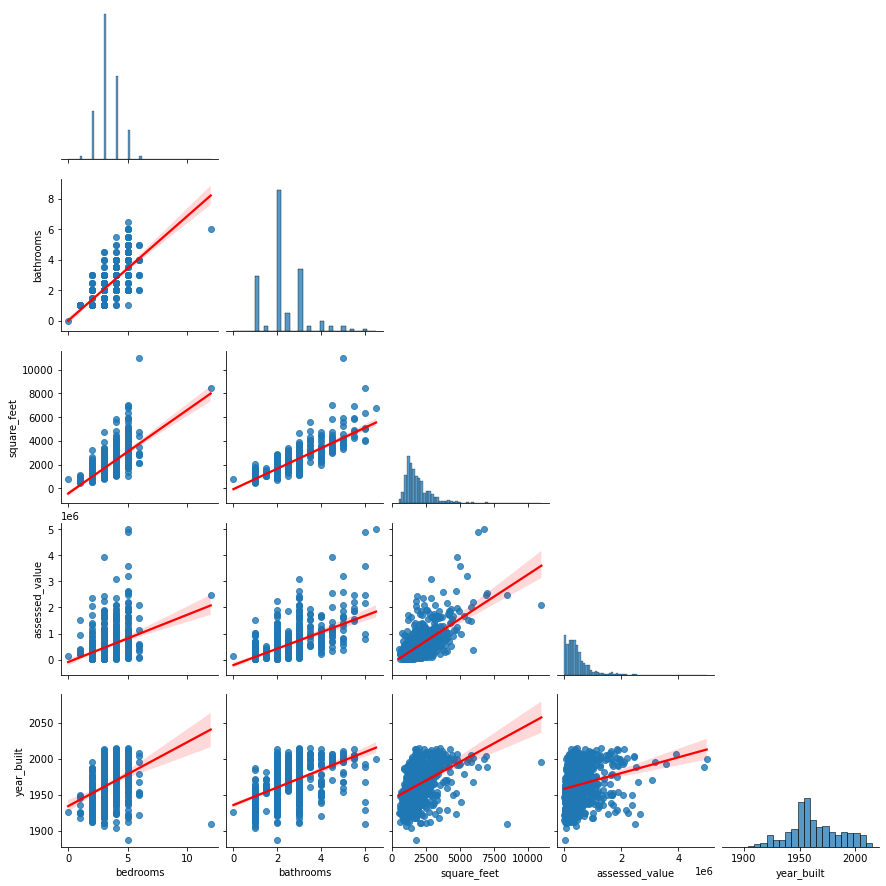

In [7]:
cont_cols = ['bedrooms','bathrooms','square_feet', 'assessed_value', 'year_built']
explore.plot_variable_pairs(df[cont_cols].sample(1000))

#### Visualization Takeaways

When looking at the pairplot, it appeared square feet, bedrooms, and bathrooms had the strongest correlation with assessed value. 

---

### EXPLORE - Questions

1. Is square feet of a property a driver of property value while controling for location?
2. Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
3. Is the square footage a driver of the value of a property when controllng for bedrooms?
4. Is the square footage a driver of the value of a property when controllng for bathrooms?

### QUESTION 1: SQFT, CONTROLLING LOCATION

#### Is square feet of a property a driver of property value while controlling for location?

### Visualization 

In [8]:
# Set x and y
x = train.square_feet
y = train.assessed_value

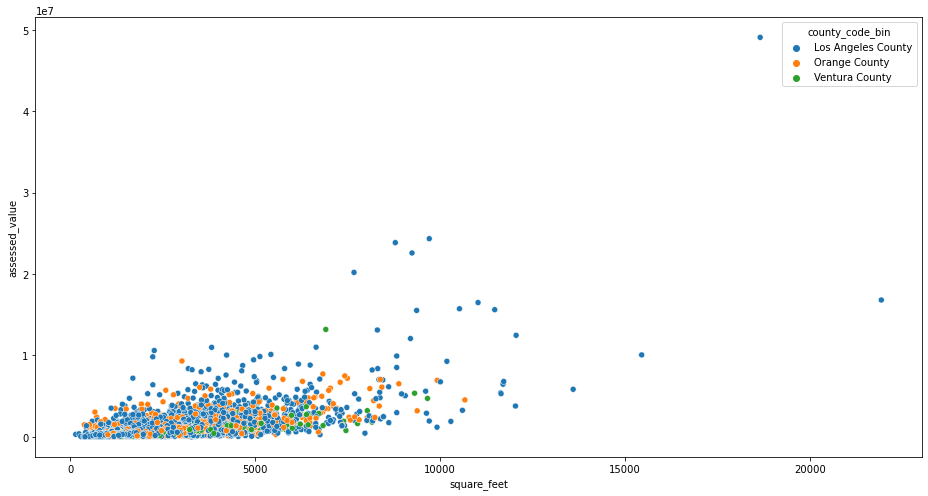

In [9]:
# Set size of figure
plt.figure(figsize = (13,7)) 
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")
# fit labels and legend
plt.tight_layout() 
plt.show()

This visualization is not very helpful, given the scale.
Adjusting the x and y limits help some, as seen below.

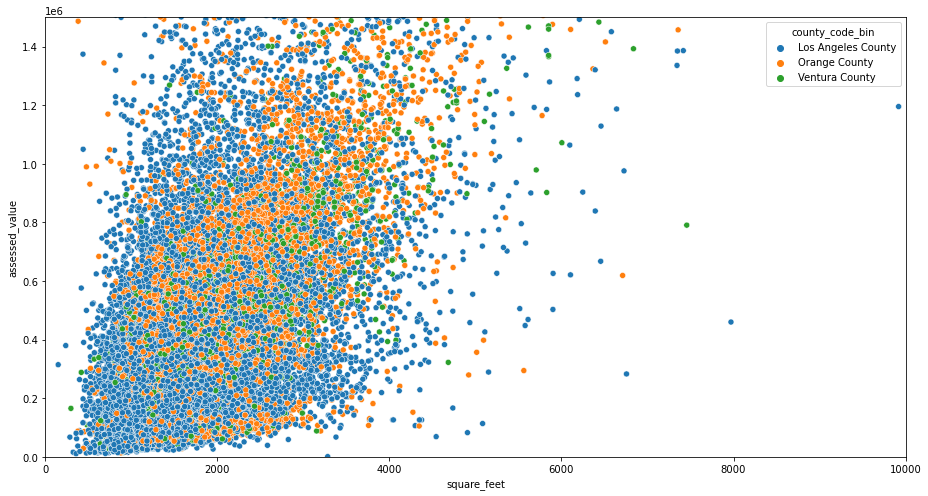

In [10]:
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
# fit labels and legend
plt.tight_layout() 
plt.show()

Although more information is clear in this visualization, such as the Los Angelas County homes being lower in value and square footage, it would be more helpful to isolate the counties visually. 

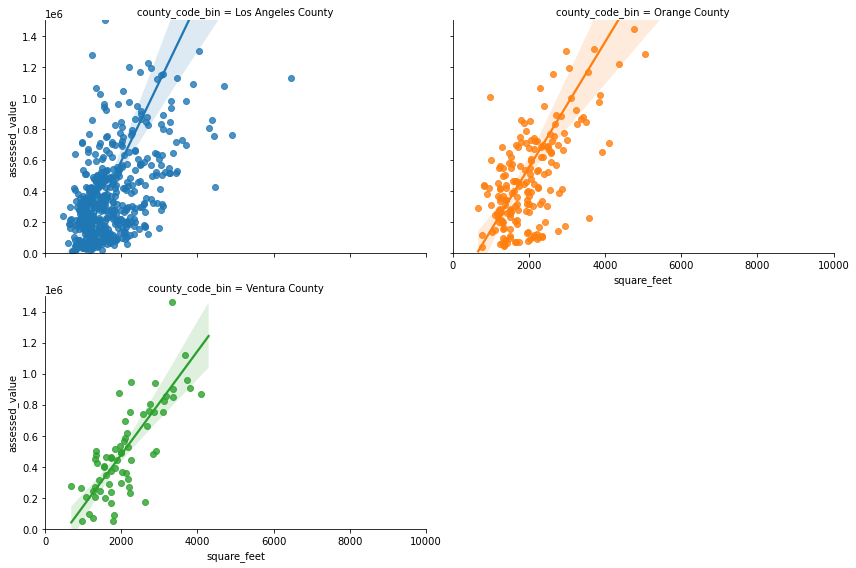

In [11]:
# Create scatterplot lm plot with sample of 800 for visual clarity
ax = sns.lmplot(x="square_feet", y="assessed_value", col="county_code_bin", hue="county_code_bin",
               data=train.sample(800), col_wrap=2, height=4, aspect=1.5)
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
# fit labels and legend
plt.tight_layout() 
plt.show()

### Takeaways

The visualization shows a correlation between square footage and assessed value. As square footage goes up, the assessed value also goes up. The vosualization also shows that the correlation is very similar across the counties. 

### Hypothesis Testing

- H0 - There is no linear relationship between square footage and assessed value.
- H1 - There is a linear realtionship between square footage and assessed value.

In [12]:
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.6068549092727483
p = 0.0
We reject the H0.


### ANSWER 1: Yes, square footage correlates with assessed value (r = 0.60).

## QUESTION 2: NUMBER of ROOMS & SQUARE FOOTAGE

### Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?

### Visualization 

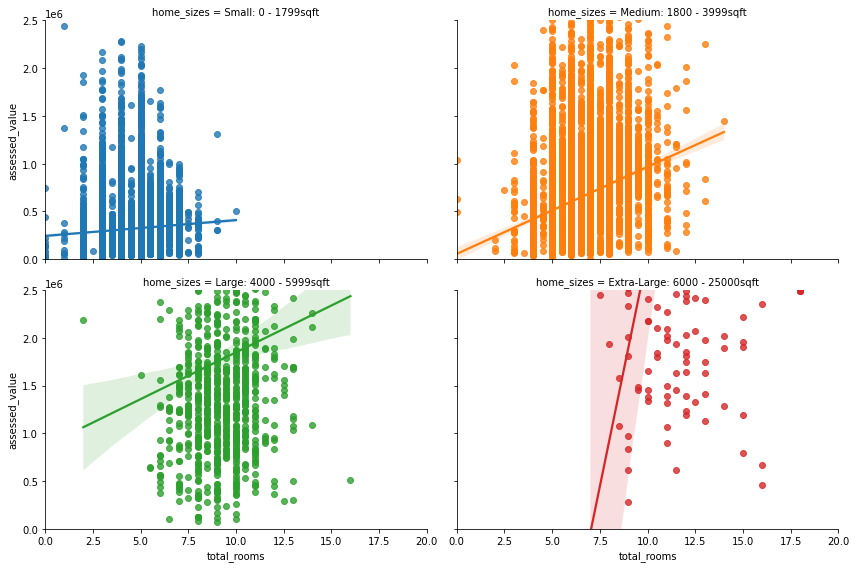

In [13]:
x = train.total_rooms
y = train.assessed_value
ax = sns.lmplot(x="total_rooms", y="assessed_value", col="home_sizes", hue="home_sizes",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 20),ylim= (0, 2500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()

### Takeaways

This visualization shows a difference in correlation between total rooms and assessed value depending upon total size of the home. the larger the square footage the more correlated total rooms are to assessed value. 

### Hypothesis Testing

- H0 - There is no linear relationship between number of rooms and assessed value.
- H1 - There is a linear realtionship between number of rooms and assessed value.

In [14]:
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.44794634849505816
p = 0.0
We reject the H0.


In [15]:
train.groupby('home_sizes').apply(lambda subset: stats.pearsonr(subset.total_rooms, subset.assessed_value))

home_sizes
Small: 0 - 1799sqft              (0.06781426979257359, 1.9553836769825387e-18)
Medium: 1800 - 3999sqft          (0.19569426411413313, 1.1210032589776008e-99)
Large: 4000 - 5999sqft           (0.11523260655747194, 0.00038874847143483546)
Extra-Large: 6000 - 25000sqft     (0.5044202832911978, 2.6297036656391532e-14)
dtype: object

When looking at the individual correlation for each house size, we see they support the visualization above, showing that smaller homes have a lower correlation bewteen total rooms and assessed value, while Extra-Large homes hae a correlation .56.

### ANSWER 2: Yes, number of rooms correlates with assessed value (r = 0.44).

## QUESTION 3: Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?

### Visualization 

In [16]:
x = train.square_feet
y = train.assessed_value

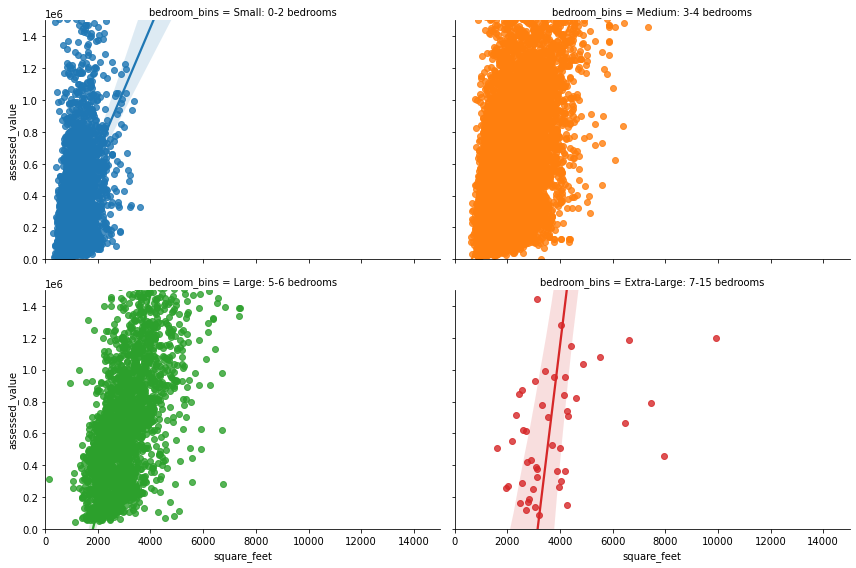

In [17]:
ax = sns.lmplot(x="square_feet", y="assessed_value", hue="bedroom_bins", col="bedroom_bins",
               data=train,col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 15000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()

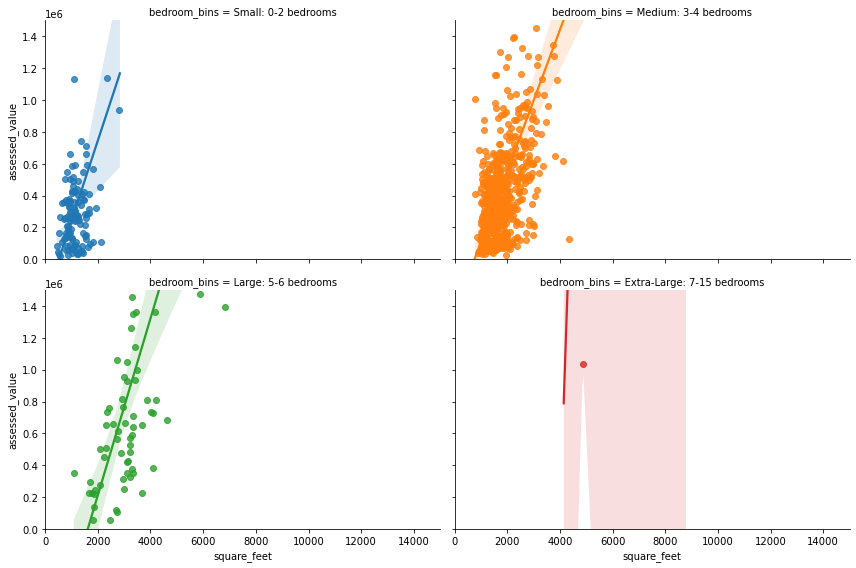

In [18]:
ax = sns.lmplot(x="square_feet", y="assessed_value", hue="bedroom_bins", col="bedroom_bins",
               data=train.sample(800),col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 15000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()

### Hypothesis Testing

- H0 - There is no linear relationship between square footage and assessed value.

- H1 - There is a linear realtionship between square footage and assessed value.

In [19]:
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)

r = 0.6068549092727483
p = 0.0


### ANSWER 3: 

## Exploration Takeaways:

---

## DATA MODELING

Process of modeling involved:
- Set X and y with target as assessed_value
- Feature Engineering with RFE
- Set Baseline
- Create 4 models:
    - LinearRegression (OLS)
    - LASSO + LARS
    - Polynomial Regression
    - TweedieRegressor (GLM)
- Evaluate the models

In [37]:
target = "assessed_value"
columns = ['bedrooms', 'bathrooms','square_feet', 'year_built', 'total_rooms', 'county_code_bin_Orange County', 'county_code_bin_Ventura County']
# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train[columns]
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate[columns]
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test[columns]
y_test = test[target]

In [39]:
#Observe size of train, validate, teest splits
X_train.shape, X_validate.shape, X_test.shape

((29298, 7), (12557, 7), (10464, 7))

### Feature Selection - Recursive Feature Elimination 

In [22]:
model = LinearRegression()
# Make the thing
rfe = RFE(model, n_features_to_select=3)
# Fit the thing
rfe.fit(X_train, y_train)
# Obtain results in dataframe
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=X_train.columns).sort_values(by = 'rfe_ranking')

,rfe_ranking
bedrooms,1
bathrooms,1
total_rooms,1
county_code_bin_Orange County,2
year_built,3
county_code_bin_Ventura County,4
square_feet,5


### Baseline

In [23]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. compute assessed_value_pred_median
y_train['baseline'] = y_train['assessed_value'].median()
y_validate['baseline'] = y_train.assessed_value.median()

### LinearRegression (OLS)

In [24]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. compute assessed_value_pred_median
y_train['baseline'] = y_train['assessed_value'].median()
y_validate['baseline'] = y_train.assessed_value.median()

### LASSO + LARS

In [25]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.assessed_value)

# predict train
y_train['assessed_value_pred_lasso_lars'] = lars.predict(X_train)
y_validate['assessed_value_pred_lasso_lars']= lars.predict(X_validate)

### Polynomial Regression

In [26]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [27]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.assessed_value)

# predict train
y_train['assessed_value_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['assessed_value_pred_lm2'] = lm2.predict(X_validate_degree2)

In [28]:
y_test = pd.DataFrame(y_test)

### TweedieRegressor (GLM)

In [30]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.assessed_value)

# predict train & validate
y_train['assessed_value_pred_glm'] = glm.predict(X_train)
y_validate['assessed_value_pred_glm'] = glm.predict(X_validate)

### Best Models

In [31]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our test data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2, y_test.assessed_value)

# predict train
y_test['assessed_value_pred_lm2'] = lm2.predict(X_test_degree2)


In [32]:
model_results = pd.concat([
    y_train.apply(lambda col: mean_squared_error(y_train.assessed_value, col)**(1/2)).rename('train'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.assessed_value, col)**(1/2)).rename('validate')
], axis=1)
model_results.sort_values('validate')

,train,validate
assessed_value,0.000000,0.000000
assessed_value_pred_lasso_lars,608552.805054,513868.465187
assessed_value_pred_lm2,543097.201984,516091.074971
assessed_value_pred_glm,787845.302161,659678.615742
baseline,803309.804199,675347.013885


In [34]:
model_results = pd.concat([
    y_train.apply(lambda col: mean_squared_error(y_train.assessed_value, col)**(1/2)).rename('train'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.assessed_value, col)**(1/2)).rename('validate'),
    y_test.apply(lambda col: mean_squared_error(y_test.assessed_value, col)**(1/2)).rename('test')
], axis=1)
model_results

,train,validate,test
assessed_value,0.000000,0.000000,0.000000
baseline,803309.804199,675347.013885,NaN
assessed_value_pred_lasso_lars,608552.805054,513868.465187,NaN
assessed_value_pred_lm2,543097.201984,516091.074971,535871.035087
assessed_value_pred_glm,787845.302161,659678.615742,NaN


---

## CONCLUSION

### Summary
The goal of this report was to identify drivers of property tax assessed value for Single Family Residences, and to construct an improved Machine Learning Regression Model to predict property tax assessed values for these properties using the features of the properties themselves. Additionally, this report aimed to make recommendations on what does and doesn't impact property values 

Through the process of data acquisition, preparation, exploration, and statistical testing, it was determined drivers of property tax assessed value for Single Family Residences were (in order of significance):

- 1. total rooms (bedrooms and bathrooms combined)
- 1. location -> Orange County
- 1. loaction -> Ventura County
- 1. location -> Los Angeles County
- 2. year built
- 3. square feet

By using these more prominent features in multiple Machine Learning Regression models, predictions of property value were made with the best performing model, a Polynomial Regression Model with a degree of 2, producing an RMSE of 549_380 on Validate.

### Recommendations

- USE THE IDENTIFIED DRIVERS of HOME VALUES: The data shows total rooms and location have the largest impact on property values. These features should be used going forward to predict home values, as well as a starting point for conducting further analysis.  

- BUILD UPON MODEL PERFORMANCE: Although the Polynomial Regression Model does predict home values with an RMSE of 549_380, the model could continue to be improved upon through deeper analysis of home features and their impact on property values. See next steps. 

- CONTINUE to PINPOINT HOME FEATURES: It is recommended further analysis and modeling be done with additional property features in order to create models with improved performance. 

### Next Steps

If given more time, further exploration would be beneficial in the following areas:

- Identifying more features of properties which may be drivers of property values, such as size of lot, pools, or outbuildings. 

- Compare specific features to see which have more impact on property value, such as adding another room versus adding overall square footage. 

- Analyzing feature impact within each county and comparing the impact across counties. 
